
<b>演習問題１</b>
春学期に使用したAuto MPGデータを使って、回帰問題を多層ニューラルネットで学習せよ。春学期に得た結果との精度を比較してみよ。


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import SGDRegressor

## データをロードする

In [2]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True)

In [3]:
raw_dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1


## 前処理

### 欠損値処理

In [4]:
raw_dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [5]:
# 欠損値を消す
raw_dataset_drop = raw_dataset.dropna()
print(raw_dataset_drop.shape)

(392, 8)


### カテゴリカル属性処理

In [6]:
# カテゴリカル属性処理
dataset = pd.get_dummies(raw_dataset_drop, columns=["Origin"])

In [7]:
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_1,Origin_2,Origin_3
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,0,0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,0,0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,0,0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,0,0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,0,0


### 訓練データとテストデータを生成

In [8]:
X = dataset.iloc[:, 1:]
y = dataset.iloc[:, 0]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
print(X_train.shape, X_test.shape)

(313, 9) (79, 9)


### 正規化

In [10]:
scaler = MinMaxScaler()
X_train_scale = scaler.fit_transform(X_train)

In [11]:
X_test_scale = scaler.transform(X_test)

In [12]:
X_train_scale[:5]

array([[1.        , 0.99741602, 0.94565217, 0.77714772, 0.03067485,
        0.        , 1.        , 0.        , 0.        ],
       [0.2       , 0.04651163, 0.10326087, 0.1026368 , 0.41104294,
        0.75      , 0.        , 0.        , 1.        ],
       [0.2       , 0.1369509 , 0.34782609, 0.29685285, 0.33742331,
        0.25      , 0.        , 1.        , 0.        ],
       [0.2       , 0.05684755, 0.13586957, 0.17295152, 0.49079755,
        0.41666667, 0.        , 1.        , 0.        ],
       [0.2       , 0.0749354 , 0.22826087, 0.18882903, 0.64417178,
        0.25      , 0.        , 0.        , 1.        ]])

## モデル構築と訓練

In [13]:
# モデル構築
model = keras.Sequential()

model.add(keras.layers.Dense(64, activation="relu", input_shape=(9,)))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(64, activation="relu"))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(1))

model.build()

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [15]:
# 訓練
model.compile(optimizer = keras.optimizers.Adam(0.001),
              loss = keras.losses.MAE
             )

history = model.fit(X_train_scale, y_train, epochs=100, verbose=0, validation_split=0.3)

## 評価

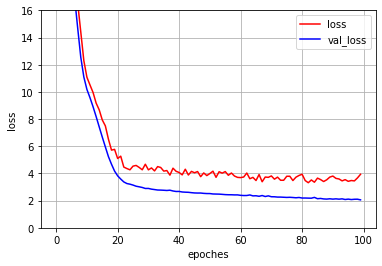

In [16]:
# 損失関数を描こう
def plt_history(history):
    plt.plot(history.history["loss"], color="red", label="loss")
    plt.plot(history.history["val_loss"], color="blue", label="val_loss")
    plt.ylim(0, 16)
    plt.xlabel("epoches")
    plt.ylabel("loss")
    plt.legend()
    plt.grid(True)
    plt.show()
    
plt_history(history)

In [17]:
# テストデータのスーコア
model.evaluate(X_test_scale, y_test)

3/3 [==============================] - 0s 7ms/step - loss: 2.4680


2.4679603576660156

## 比較

In [18]:
from sklearn.linear_model import SGDRegressor

reg = SGDRegressor(max_iter=5000, eta0=0.1)
reg.fit(X_train_scale, y_train)

SGDRegressor(eta0=0.1, max_iter=5000)

In [19]:
# MAEで損失値を計算
mean_absolute_error(y_test, reg.predict(X_test_scale))

2.8748568157936543

<b>結論</b>
春学期に得た結果と比べて、少し良い結果が出ましたが、大幅に改善では無いと思います。